# **Predicting Injury Severity from Wisconsin Crash Data**

This project aims to predict the severity of injuries resulting from motor vehicle crashes using Wisconsin’s 2022 crash dataset. This project applies data cleaning, feature selection, and build an XGBoost machine learning model to classify crash outcomes into five injury severity levels based on crash features like number of vehicles, injuries, fatalities, and contributing factors such as speeding and alcohol involvement.

To address class imbalance and improve the detection of serious and fatal injuries, the project implements class weighting during model training. The final model is evaluated using accuracy, precision, recall, and confusion matrices, and demonstrate its practical use through predictions on hypothetical crash scenarios.


# Data Loading

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# Load datasets
crash_df = pd.read_csv('2022crashdata.csv')
decode_df = pd.read_csv('decode.csv')

# Display basic info
print("Crash data shape:", crash_df.shape)
print("Decode mapping shape:", decode_df.shape)

display(crash_df.head())
display(decode_df.head())


Crash data shape: (128830, 46)
Decode mapping shape: (12, 8)


,DOCTNMBR,REPTTYPE,CRSHDATE,NTFYHOUR,CNTYNAME,MUNINAME,MUNITYPE,LOCTYPE,ONHWY,ONHWYSYS,...,BIKEFLAG,CMVFLAG,CYCLFLAG,DISTFLAG,INJTRNS,MOPFLAG,PEDFLAG,SFTYFLAG,SPEEDFLAG,TEENDRVR
0,01L00655JS,DT4000,07/16/2022,2,DANE,MADISON,C,N,012,USH,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN
1,01L00655JT,DT4000,11/22/2022,13,DANE,MADISON,C,N,012,USH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01L00655JV,DT4000,12/15/2022,1,DANE,MADISON,C,N,012,USH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01L00DBC65,DT4000,01/10/2022,8,DANE,MADISON,C,I,NaN,NaN,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01L00DBC66,DT4000,01/23/2022,13,DANE,MADISON,C,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Number,Month,Loctype,LoctypeWord,Hwyclass,HwyclassWord,Injury,InjuryWord
0,1,January,I,Intersection (public roadway),U CITY,City Street Urban,K,Fatal Injury
1,2,February,N,Non-intersection(public roadway),R CITY,City Street Rural,A,Suspected Serious Injury
2,3,March,PL,Parking lot,R TOWN,Town Road Rural,B,Suspected Minor Injury
3,4,April,PP,Private Property,U CTH,County Trunk Urban,C,Possible Injury
4,5,May,NaN,NaN,R CTH,County Trunk Rural,O,No Apparent Injury


# Data Preprocessing

In [17]:
# Map the Injury Severity Codes
injury_mapping = {'K': 4, 'A': 3, 'B': 2, 'C': 1, 'O': 0}
crash_df['INJSVR_NUM'] = crash_df['INJSVR'].map(injury_mapping)

# Drop any rows where injury severity mapping failed
crash_df = crash_df.dropna(subset=['INJSVR_NUM'])

# features used for modeling
selected_features = [
    'NTFYHOUR',        # Notification hour
    'TOTVEH',          # Total vehicles
    'TOTMOT',          # Total motor vehicles
    'TOTNMT',          # Total non-motorists
    'TOTINJ',          # Total injuries
    'TOTFATL',         # Total fatalities
    'SPEEDFLAG',       # Speed involvement
    'ALCFLAG',         # Alcohol involvement
    'DRUGFLAG',        # Drug involvement
    'PEDFLAG',         # Pedestrian involvement
]

# Keep only selected features + target
model_df = crash_df[selected_features + ['INJSVR_NUM']].copy()

# Forbinary flags (like SPEEDFLAG, ALCFLAG), treat Y as 1 and missing/other as 0
binary_cols = ['SPEEDFLAG', 'ALCFLAG', 'DRUGFLAG', 'PEDFLAG']
for col in binary_cols:
    model_df[col] = model_df[col].apply(lambda x: 1 if x == 'Y' else 0)

# Handle missing values (fill numeric columns with 0)
model_df = model_df.fillna(0)

print("Final modeling dataset shape:", model_df.shape)
display(model_df.head())


Final modeling dataset shape: (128830, 11)


,NTFYHOUR,TOTVEH,TOTMOT,TOTNMT,TOTINJ,TOTFATL,SPEEDFLAG,ALCFLAG,DRUGFLAG,PEDFLAG,INJSVR_NUM
0,2,1,1,0,1,0,0,0,0,0,1
1,13,2,2,0,0,0,0,0,0,0,0
2,1,1,2,0,0,0,0,0,0,0,0
3,8,2,2,0,1,0,0,0,0,0,1
4,13,2,1,0,0,0,0,0,0,0,0


# Basic Model Training

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20642
           1       0.57      0.60      0.58      2188
           2       0.52      0.61      0.56      2279
           3       0.38      0.05      0.09       548
           4       1.00      1.00      1.00       109

    accuracy                           0.91     25766
   macro avg       0.70      0.65      0.65     25766
weighted avg       0.91      0.91      0.91     25766

Confusion Matrix:
[[20642     0     0     0     0]
 [    0  1303   877     8     0]
 [    0   855  1387    37     0]
 [    0   119   401    28     0]
 [    0     0     0     0   109]]


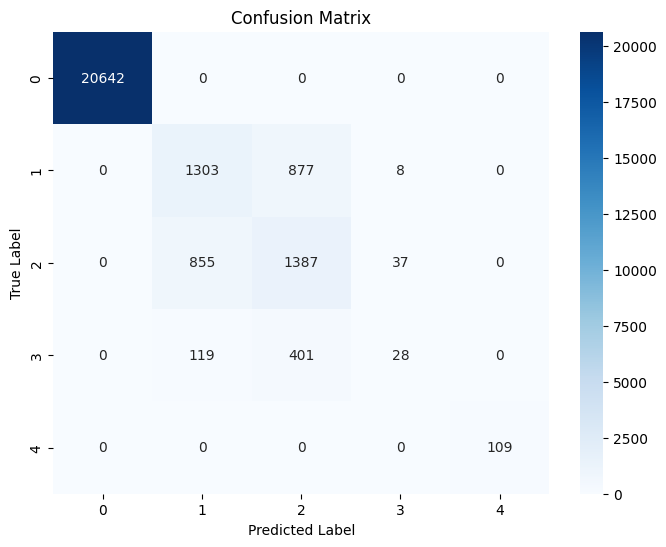

In [18]:
# features (X) and target (y)
X = model_df.drop('INJSVR_NUM', axis=1)
y = model_df['INJSVR_NUM']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # multi-class classification (5 classes: 0-4)
    num_class=5,                # 5 classes: 0,1,2,3,4
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Hyperparameter Tuning

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:33:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20642
           1       0.58      0.59      0.59      2188
           2       0.52      0.62      0.57      2279
           3       0.42      0.04      0.07       548
           4       1.00      1.00      1.00       109

    accuracy                           0.91     25766
   macro avg       0.70      0.65      0.64     25766
weighted avg       0.91      0.91      0.91     25766



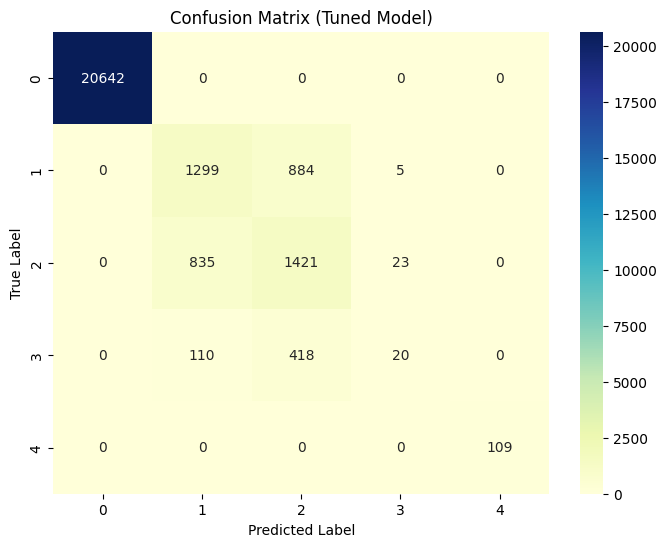

In [19]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
}

# XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=3,                  # 3-fold cross validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1              # Use all CPU cores
)

# Run the search
grid_search.fit(X_train, y_train)

# Show best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use best model to predict
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate best model
print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned Model)')
plt.show()


# Feature Importance

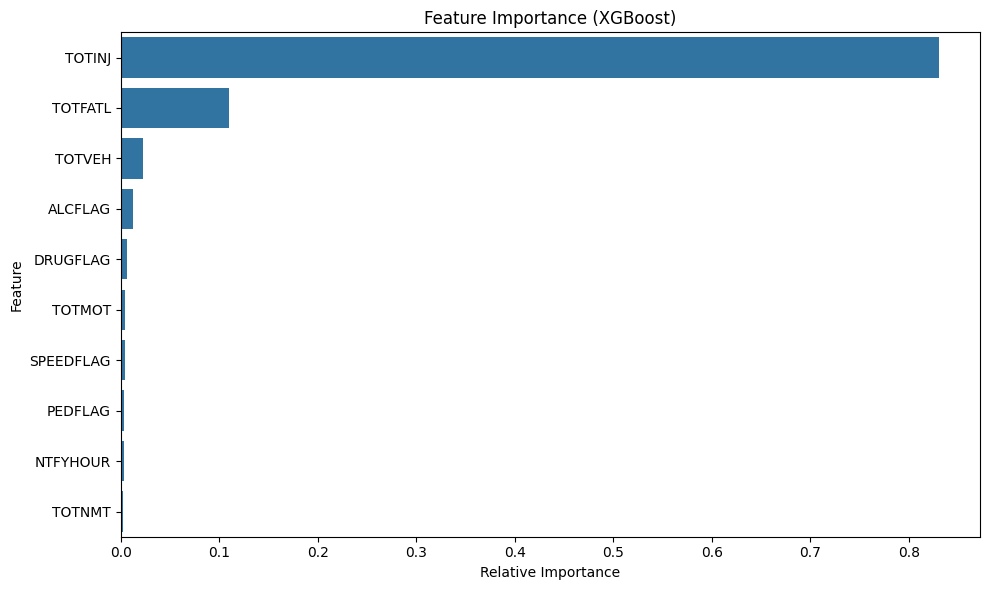

In [20]:
# Get feature importance from best model
importances = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot it
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Re-weighted XGBoost training to handle class imbalance

Class weights: {2: 11.308316875137152, 3: 47.018248175182485, 0: 1.2482015259779582, 1: 11.778742857142857, 4: 235.30593607305937}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:33:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (Weighted Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20642
           1       0.57      0.60      0.59      2188
           2       0.53      0.30      0.38      2279
           3       0.20      0.52      0.29       548
           4       1.00      1.00      1.00       109

    accuracy                           0.89     25766
   macro avg       0.66      0.68      0.65     25766
weighted avg       0.91      0.89      0.89     25766



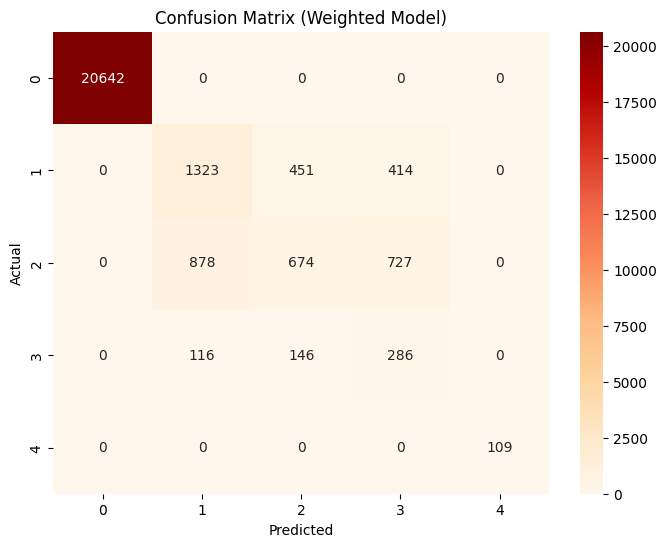

In [21]:
# Compute class frequencies
from collections import Counter

class_counts = Counter(y_train)
total = sum(class_counts.values())

# Inverse frequency weight: more weight for rare classes
class_weights = {cls: total / count for cls, count in class_counts.items()}
print("Class weights:", class_weights)

# Create a weight vector matching y_train
sample_weights = y_train.map(class_weights)

# Re-train XGBoost with weights
xgb_weighted = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_weighted.fit(X_train, y_train, sample_weight=sample_weights)

# Predict and evaluate
y_pred_weighted = xgb_weighted.predict(X_test)

print("Classification Report (Weighted Model):")
print(classification_report(y_test, y_pred_weighted))

conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_weighted, annot=True, fmt='d', cmap='OrRd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Weighted Model)')
plt.show()


# Demo Prediction on Hypothetical Crash

In [22]:
# fake crash scenario
# Example: 2 vehicles, 1 injury, speed involved but no alcohol
sample_input = pd.DataFrame([{
    'NTFYHOUR': 14,      # Time crash was reported (2 PM)
    'TOTVEH': 2,         # Total vehicles involved
    'TOTMOT': 2,         # Total motor vehicles
    'TOTNMT': 0,         # Total non-motorists
    'TOTINJ': 1,         # One injury occurred
    'TOTFATL': 0,        # No fatalities
    'SPEEDFLAG': 1,      # Speeding involved
    'ALCFLAG': 0,        # No alcohol
    'DRUGFLAG': 0,       # No drugs
    'PEDFLAG': 0         # No pedestrian involved
}])

# Predict injury severity using the weighted XGBoost model
predicted_class = xgb_weighted.predict(sample_input)[0]

# Map numeric label back to human-readable label
injury_map_rev = {
    0: 'No Apparent Injury',
    1: 'Possible Injury',
    2: 'Suspected Minor Injury',
    3: 'Suspected Serious Injury',
    4: 'Fatal Injury'
}

print("Predicted Injury Severity:", injury_map_rev[predicted_class])



Predicted Injury Severity: Possible Injury


# Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

# Create binary target: 1 = any injury, 0 = no injury (INJSVR_NUM > 0)
model_df['injury_flag'] = (model_df['INJSVR_NUM'] > 0).astype(int)

# Define features (remove TOTINJ and TOTFATL to avoid leakage)
X_bin = model_df.drop(columns=['INJSVR_NUM', 'injury_flag', 'TOTINJ', 'TOTFATL'])
y_bin = model_df['injury_flag']

# Train-test split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)

# Train logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_bin, y_train_bin)

# Predict and evaluate
y_pred_bin = logreg.predict(X_test_bin)

print("Logistic Regression Classification Report (Binary):")
print(classification_report(y_test_bin, y_pred_bin))

print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_pred_bin))

# Compute and show odds ratios
import numpy as np
odds_ratios = np.exp(logreg.coef_[0])
odds_df = pd.DataFrame({
    'Feature': X_bin.columns,
    'Odds Ratio': odds_ratios
}).sort_values(by='Odds Ratio', ascending=False)

print("\nLogistic Regression Odds Ratios (sorted):")
print(odds_df)


Logistic Regression Classification Report (Binary):
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     20642
           1       0.67      0.08      0.15      5124

    accuracy                           0.81     25766
   macro avg       0.74      0.54      0.52     25766
weighted avg       0.79      0.81      0.74     25766

Logistic Regression Confusion Matrix:
[[20438   204]
 [ 4704   420]]

Logistic Regression Odds Ratios (sorted):
     Feature  Odds Ratio
7    PEDFLAG   51.792170
5    ALCFLAG    2.453056
6   DRUGFLAG    2.403887
4  SPEEDFLAG    1.763996
3     TOTNMT    1.584655
2     TOTMOT    1.293748
1     TOTVEH    1.189192
0   NTFYHOUR    1.002215
